# BVALUE STEPS

Address seeded algorithm that explores ICMPv6 error message behavior of a remote network. 

BValue Steps traverse the target network space in steps of x bits (=8 by default). For each step 5 addresses with random IIDs are generated. This is an address seeded algorithm that requires a list of IPv6 addresses as input. In our work we relied on the IPv6 hitlist service (https://ipv6hitlist.github.io).

We rely on routing collectors to assign routed network borders to each hitlist address. For each routed network, we choose one examplary hitlist address to represent the network to avoid bias by networks with many addresses in the hitlist.

We introduced an additional step "lastbit" that equals B127 for the smallest possible subnet size. B127 is at the moment implemented as a separate measurement that only flips the last bit. 

In [1]:
# Enable auto reloading
%load_ext autoreload
%autoreload 2

In [2]:
# File handling
DEFAULT_FOLDER="data/repro/data_bvalues/"

# Files provided from input.zip
HITLIST_FILE=DEFAULT_FOLDER + "responsive-addresses.txt"
HITLIST_FILE_FILTERED=DEFAULT_FOLDER + "responsive-addresses_filtered.txt"
BGP_FILE=DEFAULT_FOLDER + "bgp.csv"
LASTBIT_FILE= DEFAULT_FOLDER + "lastbit.txt"
BVALUE_FILE=DEFAULT_FOLDER + "bvalues.txt"
BVALUE_NETS_FILE=DEFAULT_FOLDER + "bvalue_nets.txt"


# Reproduction Files
HITLIST_FILE_FILTERED_REPRO=DEFAULT_FOLDER + "responsive-addresses_filtered_REPRO.txt"
LASTBIT_FILE_REPRO= DEFAULT_FOLDER + "lastbit_REPRO.txt"
BVALUE_FILE_REPRO=DEFAULT_FOLDER + "bvalues_REPRO.txt"
BVALUE_NETS_FILE_REPRO=DEFAULT_FOLDER + "bvalue_nets_REPRO.txt"

## Requirements
The files that have been used to conduct BVALUE steps as in the paper are provided as a zip file
`data/data_bvalues/input.zip` and can be extracted with the following code.

The two required files are (the version used in the paper is included in the zip file):
1) bgp.csv
   - Source: RIPE RIS, see first tool in preparation to download BGP data from RIPE RIS
2) responsive-addresses.txt
    - Source: https://alcatraz.net.in.tum.de/ipv6-hitlist-service/open/responsive-addresses.txt.xz
   
The other files present in input.zip are a result of BVALUE tools and have been included for reproduction purposes.

In [3]:
# Extract the files included in the zip file
import zipfile
import os

# Define the path to the zip file
zip_file_path = 'data/data_bvalues/input.zip'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(DEFAULT_FOLDER)

print("Unzipping complete!")

Unzipping complete!


## Preparation

### (Skip this step for reproduction, TAKES TIME) Retrieve a current BGP dump:  tools/bgp/extract.sh
Better execute this inside a screen, e.g. `screen -S bgpdownload` and then `yes | ./tools/bgp/eval.sh`
Connects to RIPE RIS routing collectors and downloads the latest latest-bview.gz 
Requires:
```
moreutils > sponge;
bgpdump (https://github.com/RIPE-NCC/bgpdump, prereq: libbz2-dev
```

In [ ]:

# (Skip this step for reproduction) retrieve a bgp dump (the bgpdump used in the paper is provided as bgp.csv)
pkg1="bgpdump"
pkg2="moreutils"

In [ ]:
%%bash -s "$pkg1" "$pkg2"
status="$(dpkg-query -W --showformat='${db:Status-Status}' $1 2>&1)"
if [ ! $? = 0 ] || [ ! "$status" == installed ]; then
   echo "$1 is not installed, use can use 'sudo apt install $1' to install $1"
fi

status="$(dpkg-query -W --showformat='${db:Status-Status}' $2 2>&1)"
if [ ! $? = 0 ] || [ ! "$status" == installed ]; then
   echo "$2 is not installed, use can use 'sudo apt install' $2' to install $2"
fi

yes | ./tools/bgp/eval.sh


### Filter hitlist (tools/filter_addr_list_on_bgp.py)

Takes one address per routed prefix and writes them to a file to avoid bias by prefixes with many addresses in the hitlist. <br>

The following code snippet performs the filtering.

Input: <br>
```
-i data/repro/data_bvalues/responsive-addresses.txt  - Format: # in first line, then one IPv6Address per line
-r data/repro/data_bvalues/bgp.csv - Format: IPv6Network,AS Number (in the case of paths the AS numbers are separated by space and enclosed in brackets {AS1 AS2 ..})
```
Output: <br>
```
-o data/repro/data_bvalues/responsive-addresses_filtered_reproduce.txt - Format: One IPv6Address per line
```

In [3]:
# Reduce hitlist to one address per entry in the BGP tables
from bvalues.tools.filter_addr_list_on_bgp import *

tree=SubnetTree.SubnetTree()
tree=fill_tree(tree,BGP_FILE)	
filtered=filter(tree,HITLIST_FILE)
output(filtered,HITLIST_FILE_FILTERED_REPRO)

Done - error:0



### Flip lastbit (tools/lastbit/gen_lastbit.py)

Input: <br>
```
Filepath1 (Path to address file with IPv6 addresses; Format: One IPv6Address per line)
Filepath2 (Path to output file; One IPv6Address per line, first the original address, then the flipped address)
```
Output: <br>
```
Flips last bit of addresses and write the original and the flipped address to the outputfile  
```

In [6]:
# Takes the filtered hitlist and flips the last bit of the addr
from bvalues.tools.lastbit.gen_lastbit import *

addr_lookup=addr_dict(HITLIST_FILE_FILTERED)
flip_and_write_to_output(HITLIST_FILE_FILTERED, LASTBIT_FILE_REPRO, addr_lookup)

Generating Addresses


100%|███████████████████████████████████████████████████████████████████████████████████████| 52114/52114 [00:00<00:00, 54047.31it/s]

Finished - 52114 addresses were generated!
Flip errors avoided: 0



### Generate BValue Steps (tools/bvalues/gen_bvalues.py)

REPRODUCTION NOTES: The output will differ as the Interface Identifier is replaced with random bits, however the first x bits up to the current BValue are the same.

Input:
```
-i INPUTFILE, --inputfile INPUTFILE 
                      "filepath" IPv6 Address File to derive BValue
                        Addresses from (one address per line; r)
-r ROUTEDFILE, --routedfile ROUTEDFILE 
                        "filepath" BGP data in csv format of net,<optional:asn> (r)
-o OUTPUTADDR, --outputaddr OUTPUTADDR 
                        "filepath" File to store the output BValue Address (w) 
-p OUTPUTPREFIXES, --outputprefixes OUTPUTPREFIXES
                        "filepath" 
-b BITS, --bits BITS  "int" Stepwidth in bits for BValue Steps
-n NR_ADDR, --nr-addr NR_ADDR 
                        "int" Number of addresses to generate for each BValue Step
-s STOP, --stop STOP  "int" Maximum BValue Step
```

Output:
```
-o OUTPUTADDR -> File with Bvalue Addresses
-p OUTPUTPREFIXES -> File with prefixes for which Bvalues were generated
```

In [5]:
# Generate BVALUE Addresses
from bvalues.tools.bvalues.gen_bvalues import *
iterate_and_generate_bvalues(HITLIST_FILE_FILTERED, BGP_FILE, BVALUE_FILE_REPRO, BVALUE_NETS_FILE_REPRO, 8, 5, 120)

100%|████████████████████████████████████████████████████████████████████████████████████████| 52114/52114 [00:44<00:00, 1162.69it/s]

Total time needed: 44.89490866661072
Skipped 214 lines (Invalid Subnet Space)
Generated a total of: 2744710 addresses


## Measurements

> [!CAUTION]
> THIS SECTION INCLUDES ACTIVE INTERNET MEASUREMENTS (Follow good internetcitizenship, use dedicated scanning hardware, low scanrates, set a PTR explaining the reason of your scans)

> ![IMPORTANT]
> SKIP THIS STEP FOR REPRODUCTION

To reproduce, we provide our result files  
Measurements of the bvalues.csv and lastbit.csv are conducted with ZMAP. <br>
For these measurements the ZMap IPv6 Adoption from TUM can be used (https://github.com/tumi8/zmap), however we used our adoption of ZMap that is optimized for precise RTT collection. For this measurement it should be enough to change "orig-dest-ip" to "outersaddr" in tools/scan_zmap.sh` when using the TUM version.

Bash scripts that schedule the scans are provided, they source
`scan.conf` to retrieve the following variables: 
```bash
ip=<public ipv6 source address for scanning> # `ip a`; Additionally before scanning for good Internet citizenship, set a reverse dns entry on that IP explaining the reason why you perform this scan
mac=<mac address of the interface> # again `ip a`, it includes the mac address of the interface 
gw=<mac address of the gateway> # use `ip - 6 neigh`
int=<name of source interface> #use the interface name
speed=<1000, 10000, ...> # the scanrate
proto=<all, icmp, tcp, tcp_ack or udp> #the protocol to perform scans with
outdir= <output directory> # folder to store scan results
zmap=<path to zmap binary> 
```

Output (CSV with the name scanned_targets):

```bash
orig-dest-ip,classification,saddr,ttl,original_ttl,sent_timestamp_ts,sent_timestamp_us,timestamp_str,rtt
<ip>,response_type <unreach_...,timxceeded,echoreply>,<ip>,55 <0-255>,241 <0-255>,1678798693 <timestamp>,912363 <timestamp>,1678798693.946204 <timetamp>,33 <rtt in ms>
```


In [ ]:
# Input File Selection
# Set REPRODUCTION To True if you want to use your reproduced files as input
REPRODUCTION=False
if REPRODUCTION:
    INPUT_LASTBIT=LASTBIT_FILE_REPRO
    INPUT_BVALUES=BVALUES_FILE_REPRO
else:
    INPUT_LASTBIT=LASTBIT_FILE
    INPUT_BVALUES=BVALUES_FILE

In [ ]:
# Requires scan.conf variables and scanning environment to be prepared, perform LastBit measurement, prefered option is to execute within bash terminal (screen session)
%%bash -s "$INPUT_LASTBIT 
./scan_zmap.sh "$1" "lastbit"

In [ ]:
# Requires scan.conf variables and scanning environment to be prepared, perform BValue measurement, prefered option is to execute within bash terminal (screen session)
%%bash -s "$INPUT_BVALUES"
./scan_zmap.sh "$1" "bvalues"

## Evaluation

We scheduled daily scans for icmpv6, tcp and udp for 5 days in chron on 2 vantage points.  <br>
The output of those files is included in: <br>
`data/data_bvalues/lastbit_vantage1.zip`
`data/data_bvalues/lastbit_vantage2.zip`
`data/data_bvalues/bvalue_vantage1.zip`
`data/data_bvalues/bvalue_vantage2.zip`

The evaluation section analyzes the scan output

In [12]:
# Extract artifacts
REPRODUCTION=True
if REPRODUCTION:
    # Extract the files included in the measurement zip files
    import zipfile
    import os
    from pathlib import Path
    
    ZIP_PATH='data/data_bvalues/'
    # Define the path to the zip file
    zip_file_paths = [ZIP_PATH+'lastbit_vantage1.zip', ZIP_PATH+'lastbit_vantage2.zip',ZIP_PATH+'bvalue_vantage1.zip',ZIP_PATH+'bvalue_vantage2.zip']
    
    # Create a ZipFile object
    for zip_file in zip_file_paths:
        try:
            
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                # Extract all the contents of the zip file to the specified directory
                OUTPUT_FOLDER = DEFAULT_FOLDER              
                print("Unzipping {} to {}".format(zip_file,OUTPUT_FOLDER))
                zip_ref.extractall(OUTPUT_FOLDER)
        except Exception as e:
            print("Could not unzip {} with error: {}".format(zip_file,e))
    print("Unzipping complete!")

Unzipping data/data_bvalues/lastbit_vantage1.zip to data/repro/data_bvalues/
Unzipping data/data_bvalues/lastbit_vantage2.zip to data/repro/data_bvalues/
Unzipping data/data_bvalues/bvalue_vantage1.zip to data/repro/data_bvalues/
Unzipping data/data_bvalues/bvalue_vantage2.zip to data/repro/data_bvalues/
Unzipping complete!


### Create BValue Dicts for further analyzes

```
python3 bvalue_dict.py -s <path to scanned-bvalue-targets> -n <path to input bvalue-nets> -t <path to target bvalue addresses> -i <path to (optionally filtered) hitlist addresses> -o <path to output .json> -f <path to lastbit scan results> -a <path to routed networks (bgp.csv)>
```

In [13]:
# Create a BValue File for further analysis
from bvalues.tools.bvalues.bvalue_dict import *
BVALUE_FOLDER=DEFAULT_FOLDER+"bvalue_"
LASTBIT_FOLDER=DEFAULT_FOLDER+"lastbit_"
VANTAGE="vantage1"
PROTO="icmpv6"
DATE="2023_03_14"
SCAN_FILE=BVALUE_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"scanned_targets.txt"
#TARGET_FILE=BVALUE_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"targets.txt"
LASTBIT_FILE=LASTBIT_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"scanned_targets.txt"
BVALUE_DICT_OUTPUT_FILE=BVALUE_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"bvalue_dict.json"

# Aggregate Results from the lastbit measurement
responsiveness_dict=extract_responsiveness_dict(HITLIST_FILE_FILTERED,LASTBIT_FILE)
flip_dict=read_flipped_addr_results(LASTBIT_FILE,PROTO)

# Generate Metadata AS File
as_dict=create_as_dict(BGP_FILE)

# Generate a LPM tree for the input networks
tree = SubnetTree.SubnetTree()
tree = fill_tree(tree,BVALUE_NETS_FILE)

# Generate the BValue Dict
print("Starting To Create BValue Dict")
bvalue_dict=create_bvalue_dict(SCAN_FILE,  BVALUE_FILE, HITLIST_FILE_FILTERED,flip_dict, responsiveness_dict, tree ,as_dict, 8,128,PROTO,5)

# Dump the dict to the output file
with open(BVALUE_DICT_OUTPUT_FILE,'w') as f_out:
    json.dump(bvalue_dict,f_out)
    print("Finished: BValue Dict created successfully!")

Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):48135
Starting To Create BValue Dict


52114it [00:29, 1771.43it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!


### BValue Dict Evaluation

The BValue Dict can be generated for all 5 days and protocols
-> from the dict all further evaluation is done

-> bvalue_change_json.py

In [14]:
from bvalues.tools.bvalues.bvalue_change_json import *

BVALUE_CHANGE_FILE=BVALUE_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"bvalue_changes.json"
BVALUE_CHANGE_COUNT_FILE=BVALUE_FOLDER+VANTAGE+"/"+DATE+"/"+PROTO+"/"+"bvalue_changes_counts.json"

with open(BVALUE_DICT_OUTPUT_FILE,'r') as f_json:
	bvalue_dict=json.load(f_json)

results, counts, global_count = detect_changes(bvalue_dict)

create_eval_counts(results, counts, global_count)
	
with open(BVALUE_CHANGE_FILE,"w") as f:
	json.dump(results,f,indent=4)
	
with open(BVALUE_CHANGE_COUNT_FILE,"w") as f:
    json.dump(counts,f,indent=4)

### Network Border and RTT CDFs


INFO:matplotlib.font_manager:generated new fontManager
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'F', 'G', 'P', 'S', 'T', 'V', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 41, 42, 51, 54, 55, 57, 68, 70, 71, 72, 74, 75, 76, 79, 81, 82, 85, 86, 87, 88, 93]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 

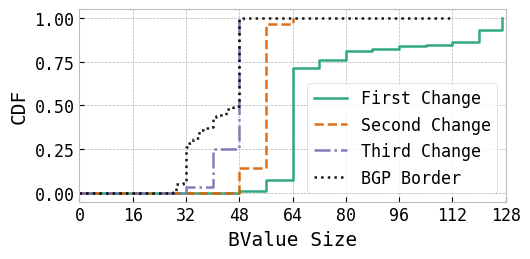

<Figure size 640x480 with 0 Axes>

In [17]:
#### CDF Borders
from bvalues.tools.bvalues.vis.cdf_borders import *

with open(BVALUE_CHANGE_FILE, 'r') as f:
    data = json.load(f)
    
# Dictionary to hold all sizes for plotting CDFs
cdf_data = {'First Change': [], 'Second Change': [], 'Third Change': [],'BGP Border':[]}
    
# Extract and organize the data from JSON
for network, targets in data.items():
    for target, changes in targets.items():
        sizes = extract_sizes(changes, network)
      
        if len(sizes) > 1:
            cdf_data['BGP Border'].append(sizes[0])
        if len(sizes) > 2:
            cdf_data['First Change'].append(sizes[1])
        if len(sizes) > 3:
            cdf_data['Second Change'].append(sizes[2])
        if len(sizes) > 3:
            cdf_data['Third Change'].append(sizes[3])
    
# Plot the CDFs
plot_cdfs(cdf_data)


#### CDF RTT Active


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'F', 'N', 'P', 'R', 'T', 'U', 'X', 'eight', 'four', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 's', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 23, 25, 27, 36, 38, 39, 41, 49, 51, 53, 55, 56, 59, 86]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 24 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'F', 'N', 'P', 'R', 'T', 'U', 'X', 'eight', 'four', 'nonmarkingreturn', 'one', 'parenleft', 'parenri

{2: 3839, 3: 11822, 18: 1597}
2
22.244756055162824
3
68.50156449182988
18
9.253679453007301


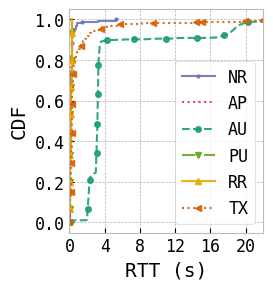

<Figure size 640x480 with 0 Axes>

In [18]:
from bvalues.tools.bvalues.vis.cdf_rtt import *

with open(BVALUE_CHANGE_FILE, 'r') as file:
    data = json.load(file)

active_status=True
df = process_data(data, active=active_status)
plot(df,active_status)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'F', 'N', 'P', 'R', 'T', 'U', 'X', 'eight', 'four', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 's', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 23, 25, 27, 36, 38, 39, 41, 49, 51, 53, 55, 56, 59, 86]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 24 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'F', 'N', 'P', 'R', 'T', 'U', 'X', 'eight', 'four', 'nonmarkingreturn', 'one', 'parenleft', 'parenri

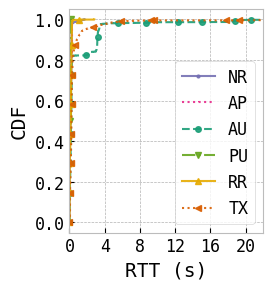

<Figure size 640x480 with 0 Axes>

In [19]:
active_status=False
df = process_data(data, active=active_status)
plot(df,active_status)

### Multi Day and Vantage Point Evaluation

In [23]:
# Repeats bvalue_generation for all vantage points, days and protocols
## Caution: This step may take some time

import json
import os
from bvalues.tools.bvalues.bvalue_change_json import detect_changes, create_eval_counts

# Define paths and constants
VANTAGES = ["vantage1", "vantage2"]
SCAN_DATES = ["2023_03_14", "2023_03_15", "2023_03_16", "2023_03_17", "2023_03_18"]
PROTOCOLS = ["icmpv6", "tcp", "udp"]  

FLAG_GEN_BVALUE_DICT=True
FLAG_GEN_BVALUE_CHANGES=True
FLAG_GEN_BVALUE_CHANGES_COUNTS=True

def generate_bvalue_dict(vantage, scan_date, protocol):
    scan_file = f"{BVALUE_FOLDER}{vantage}/{scan_date}/{protocol}/scanned_targets.txt"
    lastbit_file = f"{LASTBIT_FOLDER}{vantage}/{scan_date}/{protocol}/scanned_targets.txt"
    bvalue_dict_output_file = f"{BVALUE_FOLDER}{vantage}/{scan_date}/{protocol}/bvalue_dict.json"

    # Aggregate Results from the lastbit measurement
    responsiveness_dict = extract_responsiveness_dict(HITLIST_FILE_FILTERED, lastbit_file)
    flip_dict = read_flipped_addr_results(lastbit_file, protocol)

    # Generate Metadata AS File
    as_dict = create_as_dict(BGP_FILE)

    # Generate a LPM tree for the input networks
    tree = SubnetTree.SubnetTree()
    tree = fill_tree(tree, BVALUE_NETS_FILE)

    # Generate the BValue Dict
    print(f"Creating BValue Dict for {vantage} on {scan_date} for {protocol}")
    bvalue_dict = create_bvalue_dict(
        scan_file, BVALUE_FILE, HITLIST_FILE_FILTERED, flip_dict,
        responsiveness_dict, tree, as_dict, 8, 128, protocol, 5
    )

    # Dump the dict to the output file
    with open(bvalue_dict_output_file, 'w') as f_out:
        json.dump(bvalue_dict, f_out)
        print("Finished: BValue Dict created successfully!")



# Function to process each combination of vantage, scan date, and protocol
def process_combination(vantage, scan_date, protocol):
    bvalue_dict_path = f"{DEFAULT_FOLDER}/bvalue_{vantage}/{scan_date}/{protocol}/bvalue_dict.json"
    bvalue_change_file = f"{DEFAULT_FOLDER}/bvalue_{vantage}/{scan_date}/{protocol}/bvalue_changes.json"
    bvalue_change_count_file = f"{DEFAULT_FOLDER}/bvalue_{vantage}/{scan_date}/{protocol}/bvalue_changes_counts.json"

    if FLAG_GEN_BVALUE_DICT:
        generate_bvalue_dict(vantage, scan_date, protocol)
    
    # Load the bvalue_dict JSON file
    with open(bvalue_dict_path, 'r') as f_json:
        bvalue_dict = json.load(f_json)
    
    # Perform Change Detection
    results, counts, global_count = detect_changes(bvalue_dict)

    # Create Evaluation Counts
    create_eval_counts(results, counts, global_count)

    if FLAG_GEN_BVALUE_CHANGES:
        # Write results to the bvalue_changes.json file
        with open(bvalue_change_file, "w") as f:
            json.dump(results, f, indent=4)
    
    if FLAG_GEN_BVALUE_CHANGES_COUNTS:
        # Write counts to the bvalue_changes_counts.json file
        with open(bvalue_change_count_file, "w") as f:
            json.dump(counts, f, indent=4) 

# Main loop to process all combinations
for vantage in VANTAGES:
    for protocol in PROTOCOLS:
        for scan_date in SCAN_DATES:
            print(f"Processing {protocol}:{scan_date} for {vantage}")
            process_combination(vantage, scan_date, protocol)



Processing icmpv6:2023_03_14 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):48135
Creating BValue Dict for vantage1 on 2023_03_14 for icmpv6


52114it [00:29, 1773.55it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_15 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47951
Creating BValue Dict for vantage1 on 2023_03_15 for icmpv6


52114it [00:29, 1787.26it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_16 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47802
Creating BValue Dict for vantage1 on 2023_03_16 for icmpv6


52114it [00:28, 1813.78it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_17 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47728
Creating BValue Dict for vantage1 on 2023_03_17 for icmpv6


52114it [00:28, 1810.42it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_18 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47664
Creating BValue Dict for vantage1 on 2023_03_18 for icmpv6


52114it [00:28, 1819.46it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_14 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):48135
Creating BValue Dict for vantage1 on 2023_03_14 for tcp


52114it [00:27, 1883.09it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_15 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47951
Creating BValue Dict for vantage1 on 2023_03_15 for tcp


52114it [00:27, 1870.33it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_16 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47802
Creating BValue Dict for vantage1 on 2023_03_16 for tcp


52114it [00:27, 1878.49it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_17 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47728
Creating BValue Dict for vantage1 on 2023_03_17 for tcp


52114it [00:27, 1877.61it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_18 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47664
Creating BValue Dict for vantage1 on 2023_03_18 for tcp


52114it [00:27, 1881.12it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_14 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):48135
Creating BValue Dict for vantage1 on 2023_03_14 for udp


52114it [00:28, 1842.39it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_15 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47951
Creating BValue Dict for vantage1 on 2023_03_15 for udp


52114it [00:28, 1839.91it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_16 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47802
Creating BValue Dict for vantage1 on 2023_03_16 for udp


52114it [00:28, 1848.75it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_17 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47728
Creating BValue Dict for vantage1 on 2023_03_17 for udp


52114it [00:28, 1848.14it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_18 for vantage1
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47664
Creating BValue Dict for vantage1 on 2023_03_18 for udp


52114it [00:28, 1849.01it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_14 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47580
Creating BValue Dict for vantage2 on 2023_03_14 for icmpv6


52114it [00:28, 1800.81it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_15 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47509
Creating BValue Dict for vantage2 on 2023_03_15 for icmpv6


52114it [00:28, 1806.33it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_16 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47640
Creating BValue Dict for vantage2 on 2023_03_16 for icmpv6


52114it [00:28, 1809.57it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_17 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47445
Creating BValue Dict for vantage2 on 2023_03_17 for icmpv6


52114it [00:28, 1802.12it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing icmpv6:2023_03_18 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47500
Creating BValue Dict for vantage2 on 2023_03_18 for icmpv6


52114it [00:28, 1807.92it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_14 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47580
Creating BValue Dict for vantage2 on 2023_03_14 for tcp


52114it [00:27, 1874.89it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_15 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47509
Creating BValue Dict for vantage2 on 2023_03_15 for tcp


52114it [00:27, 1879.80it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_16 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47640
Creating BValue Dict for vantage2 on 2023_03_16 for tcp


52114it [00:27, 1875.34it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_17 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47445
Creating BValue Dict for vantage2 on 2023_03_17 for tcp


52114it [00:27, 1876.15it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing tcp:2023_03_18 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47500
Creating BValue Dict for vantage2 on 2023_03_18 for tcp


52114it [00:27, 1878.55it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_14 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47580
Creating BValue Dict for vantage2 on 2023_03_14 for udp


52114it [00:28, 1843.12it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_15 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47509
Creating BValue Dict for vantage2 on 2023_03_15 for udp


52114it [00:28, 1839.24it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_16 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47640
Creating BValue Dict for vantage2 on 2023_03_16 for udp


52114it [00:28, 1843.06it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_17 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47445
Creating BValue Dict for vantage2 on 2023_03_17 for udp


52114it [00:28, 1836.64it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!
Processing udp:2023_03_18 for vantage2
Total Hitlist Addresses:52114
Responsive Hitlist Addresses (ICMPv6/TCP443/UDP53):47500
Creating BValue Dict for vantage2 on 2023_03_18 for udp


52114it [00:28, 1848.45it/s]


Skipped small prefixes >=120:213
Finished: BValue Dict created successfully!


In [28]:
# BValue Steps - Changes Overview Table 5 Days, 3 Protocols, based on bvalue_change_counts.json Files
from bvalues.tools.bvalues.latex.create_latex_change_table import *
latex_table = generate_table(DEFAULT_FOLDER)
print(latex_table)

bvalue_vantage1/2023_03_14/icmpv6/bvalue_changes_counts.json
bvalue_vantage1/2023_03_15/icmpv6/bvalue_changes_counts.json
bvalue_vantage1/2023_03_16/icmpv6/bvalue_changes_counts.json
bvalue_vantage1/2023_03_17/icmpv6/bvalue_changes_counts.json
bvalue_vantage1/2023_03_18/icmpv6/bvalue_changes_counts.json
bvalue_vantage2/2023_03_14/icmpv6/bvalue_changes_counts.json
bvalue_vantage2/2023_03_15/icmpv6/bvalue_changes_counts.json
bvalue_vantage2/2023_03_16/icmpv6/bvalue_changes_counts.json
bvalue_vantage2/2023_03_17/icmpv6/bvalue_changes_counts.json
bvalue_vantage2/2023_03_18/icmpv6/bvalue_changes_counts.json
bvalue_vantage1/2023_03_14/tcp/bvalue_changes_counts.json
bvalue_vantage1/2023_03_15/tcp/bvalue_changes_counts.json
bvalue_vantage1/2023_03_16/tcp/bvalue_changes_counts.json
bvalue_vantage1/2023_03_17/tcp/bvalue_changes_counts.json
bvalue_vantage1/2023_03_18/tcp/bvalue_changes_counts.json
bvalue_vantage2/2023_03_14/tcp/bvalue_changes_counts.json
bvalue_vantage2/2023_03_15/tcp/bvalue_chan

In [36]:
# BValue Steps - Network Activity Classification for active and inactive prefixes; Overview Table 5 Days, 3 Protocols, based on bvalue_change_counts.json Files
from bvalues.tools.bvalues.latex.create_latex_label_table import *
latex_table = generate_label_table(DEFAULT_FOLDER)
print(latex_table)

{'0': {'icmpv6': np.float64(18251.0), 'tcp': np.float64(15493.600000000002), 'udp': np.float64(22205.1)}, '1': {'icmpv6': np.float64(10348.0), 'tcp': np.float64(8365.400000000001), 'udp': np.float64(11539.7)}}
\begin{table}[t]
    \renewcommand{\arraystretch}{1.2}
    \centering
    \tiny
    \resizebox{\linewidth}{!}{
    \begin{tabular}{ | c| l r r r | r r r |}
\cline{3-8}
 \multicolumn{2}{c}{} & \multicolumn{3}{|c|}{\textbf{labeled active}} & \multicolumn{3}{c|}{\textbf{labeled inactive}} \\ 
 \multicolumn{2}{c}{}& \multicolumn{1}{|c}{Netw.} &  \multicolumn{1}{c}{$\sigma$} &  \multicolumn{1}{c|}{\%} & \multicolumn{1}{c}{Netw.} &  \multicolumn{1}{c}{$\sigma$} &  \multicolumn{1}{c|}{\%} \\ 
 \hline
\multirow{3}{*}{\rotatebox{90}{\textbf{active}}} & ICMPV6 & 17,361 & 109 & \Chart{0.951} & 471 & 11 & \Chart{0.046} \\ 
 & TCP & 14,522 & 112 & \Chart{0.937} & 620 & 12 & \Chart{0.074} \\ 
 & UDP & 12,490 & 82 & \Chart{0.562} & 3,687 & 35 & \Chart{0.320} \\ 
 \hline
\multirow{3}{*}{\rotateb

In [37]:
# Create Latex Table for Appendix showing the number of responses per BValue Step and the number of different message types

from bvalues.tools.bvalues.latex.create_latex_bvaluetruthtable import *

generate_table_types_responses(DEFAULT_FOLDER)



{'icmpv6': {'0': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '1': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '2': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '3': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '4': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '5': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}}, 'tcp': {'0': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '1': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '2': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '3': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '4': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '5': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}}, 'udp': {'0': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '1': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '2': {'0': [], '1': [], '2': [], '3': [], '4': [], '5': []}, '3': {'0': [], '1': [], '2': [], '3': [], '4': [], '5':